In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import random
import scipy 
from scipy.optimize import minimize
from numpy import array
from sklearn.metrics import r2_score
from scipy import stats
from scipy.spatial.distance import pdist
from skbio.stats.distance import permanova
from skbio import DistanceMatrix
import warnings
warnings.filterwarnings("ignore")

# Read metadata

In [2]:
df_meta = pd.read_csv('../../../our_data/meta_data.csv', index_col=0)
df_scfa = pd.read_csv('../../../our_data/SCFA.csv', index_col=0)
df_meta_scfa = pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')
df_meta_scfa.head()

,MiceID,Vendor,Day,Diet,RandomizedGroup,Acetate,Propionate,Butyrate,Total
SampleID,,,,,,,,,
sample131,BC1,Beijing,0,Control,C,20.205741,3.297966,2.729283,26.741973
sample132,BC2,Beijing,0,Control,B,15.789550,2.520570,2.439410,21.178312
sample133,BC3,Beijing,0,Control,A,25.064928,5.569482,2.176445,34.101622
sample134,BC4,Beijing,0,Control,D,16.980939,3.224844,2.513462,23.310672
sample135,BC5,Beijing,0,Control,E,21.801265,4.224119,3.107713,29.891000


# Fit harmonic oscillator model (for each SCFA and each mice)

In [3]:
def harmonic(params,xdata):
    k1,k2,D,H,Ai = params
    ypred = H/k1/k2+((D+k2*Ai-H/k1)*np.exp(-k1*xdata)-(D+k1*Ai-H/k2)*np.exp(-k2*xdata))/(k2-k1)
    return ypred

In [4]:
def hill_function(params,xdata):
    A1,n,K,Ai = params
    ypred = Ai+A1*(xdata**n)/(xdata**n+K**n)
    return ypred

In [5]:
def residual_harmonic(params,xdata,ydata):
    ypred = harmonic(params,xdata)
    return -r2_score(ydata, ypred)

In [6]:
def residual_hill(params,xdata,ydata):
    ypred = hill_function(params,xdata)
    return -r2_score(ydata, ypred)

In [40]:
df_meta_scfa_inulin = df_meta_scfa[df_meta_scfa.Diet=='Inulin']
all_mice = list(set(df_meta_scfa_inulin.MiceID))
initial_condition = 'fixedIC' # free initial condition or fixed initial condition

lines = []
for i, scfa_ in enumerate(['Acetate','Propionate','Butyrate','Total']):
    for j, mice_ in enumerate(all_mice):
        curr_df = df_meta_scfa_inulin[df_meta_scfa_inulin.MiceID==mice_].sort_values(by='Day')
        vendor_ = list(set(curr_df.Vendor))[0]
        
        # get X and Y data
        xdata = np.array(curr_df.Day)
        ydata = np.array(curr_df[scfa_])

        # model fitting
        min_obj_over = 1e10
        best_sol_over = None
        trial=0
        while trial < 100:
            try:
                if initial_condition=='freeIC':
                    res = minimize(residual_harmonic, 
                                   [random(),random(),random(),random(),random()], 
                                   args=(xdata,ydata),
                                   bounds = ((0, 1), (0, 1), (0, None), (0, None), (0,None)),
                                   method='Powell', # Powell
                                   tol=1e-8,
                                   options={'maxiter':1000}
                                  )
                elif initial_condition=='fixedIC':
                    res = minimize(residual_harmonic, 
                       [random(),random(),random(),random(),ydata[0]], 
                       args=(xdata,ydata),
                       bounds = ((0, 1), (0, 1), (0, None), (0, None), (ydata[0],ydata[0])),
                       method='Powell', # Powell
                       tol=1e-8,
                       options={'maxiter':1000}
                      )
                else:
                    print('unknown initial condition: %s'%(initial_condition))
                    raise
                assert res.success==True
                if res.fun < min_obj_over:
                    best_sol_over = res.x
                    min_obj_over = res.fun
                trial += 1
            except:
                pass
        print(scfa_, mice_)
        print(best_sol_over)
        lines.append([mice_, vendor_, scfa_] + list(best_sol_over) + [r2_score(ydata, harmonic(best_sol_over, xdata))])

# write to file
df_bfit = pd.DataFrame(lines, columns=['MiceID','Vendor','SCFA','k1','k2','D','H','Ai','R2'])
df_bfit['zeta'] = [(k1+k2)/2/np.sqrt(k1*k2) for k1,k2 in zip(df_bfit['k1'],df_bfit['k2'])]
df_bfit.to_csv('best_fit_parameters_inulin_%s_harmonic.csv'%(initial_condition))

Acetate GI4
[0.03023044 0.28954908 7.93554741 0.0167699  8.4866322 ]
Acetate GI3
[ 0.42694985  0.4269503  18.90834302  3.73490798  8.6126283 ]
Acetate BI1
[ 0.57480079  0.57480041 23.76109175  5.38860023  5.23389922]
Acetate HI5
[ 0.23522746  0.23522739  4.65063896  0.66296165 13.79321843]
Acetate HI2
[ 0.39003852  0.39003865 15.52487899  2.13348848  2.06124266]
Acetate SI1
[ 0.22256115  0.22256115 17.03300103  0.37051636  3.65146118]
Acetate SI4
[ 0.0784891   1.         18.87516684  0.86393623  7.91718273]
Acetate SI5
[ 0.2899772   0.28997721  7.6953416   1.12961841 10.29078305]
Acetate HI4
[ 0.0881517   0.08815301  1.31528809  0.07215377 11.09616374]
Acetate GI1
[3.73339165e-09 3.46384662e-01 2.62972364e+00 7.41841213e-02
 1.24667730e+01]
Acetate BI4
[3.73768597e-09 9.99999982e-01 4.93123126e+00 1.11894517e-01
 1.25803680e+01]
Acetate BI2
[ 0.08110385  0.08110367  1.40277012  0.05113775 13.45982298]
Acetate HI1
[5.60683174e-02 5.59675840e-02 1.71015967e+00 5.99786560e-10
 9.12634780e

In [8]:
df_meta_scfa_inulin = df_meta_scfa[df_meta_scfa.Diet=='Inulin']
all_mice = list(set(df_meta_scfa_inulin.MiceID))
initial_condition = 'fixedIC' # free initial condition or fixed initial condition

lines = []
for i, scfa_ in enumerate(['Acetate','Propionate','Butyrate','Total']):
    for j, mice_ in enumerate(all_mice):
        curr_df = df_meta_scfa_inulin[df_meta_scfa_inulin.MiceID==mice_].sort_values(by='Day')
        vendor_ = list(set(curr_df.Vendor))[0]
        
        # get X and Y data
        xdata = np.array(curr_df.Day)
        ydata = np.array(curr_df[scfa_])

        # model fitting
        min_obj_over = 1e10
        best_sol_over = None
        trial=0
        while trial < 100:
            try:
                if initial_condition=='freeIC':
                    res = minimize(residual_hill, 
                                   [random(),random(),random(),random()], 
                                   args=(xdata,ydata),
                                   bounds = ((0, 100), (0, 10), (0, 31), (0, None)),
                                   method='Powell', # Powell
                                   tol=1e-8,
                                   options={'maxiter':1000}
                                  )
                elif initial_condition=='fixedIC':
                    res = minimize(residual_hill, 
                       [random(),random(),random(),ydata[0]], 
                       args=(xdata,ydata),
                       bounds = ((0, 100), (0, 10), (0, 31), (ydata[0],ydata[0])),
                       method='Powell', # Powell
                       tol=1e-8,
                       options={'maxiter':1000}
                      )
                else:
                    print('unknown initial condition: %s'%(initial_condition))
                    raise
                assert res.success==True
                if res.fun < min_obj_over:
                    best_sol_over = res.x
                    min_obj_over = res.fun
                trial += 1
            except:
                pass
        print(scfa_, mice_)
        print(best_sol_over)
        lines.append([mice_, vendor_, scfa_] + list(best_sol_over) + [r2_score(ydata, hill_function(best_sol_over, xdata))])

# write to file
df_bfit = pd.DataFrame(lines, columns=['MiceID','Vendor','SCFA','A1','n','K','Ai','R2'])
df_bfit.to_csv('best_fit_parameters_inulin_%s_hill.csv'%(initial_condition))

Acetate SI2
[4.31365949e-14 9.99959972e+00 3.09997011e+01 2.00154278e+01]
Acetate BI5
[6.95280642 9.02268911 0.03835036 8.06512734]
Acetate GI3
[14.89464902 10.          0.95319343  8.6126283 ]
Acetate BI1
[13.41799931 10.          0.90818076  5.23389922]
Acetate HI2
[14.32266383 10.          0.874514    2.06124266]
Acetate BI3
[ 2.47208425  9.99999999 31.         18.07537795]
Acetate BI4
[14.88805594  0.24816433 31.         12.58036796]
Acetate GI4
[15.15486562  2.7167236   0.95811509  8.4866322 ]
Acetate HI5
[ 2.39183176 10.          1.36455535 13.79321843]
Acetate SI3
[7.25412335 9.2246992  0.02766071 5.0557566 ]
Acetate HI1
[ 8.51713268 10.          5.55992145  9.1263478 ]
Acetate SI5
[5.89760825e+00 6.66408869e+00 7.81110782e-03 1.02907830e+01]
Acetate GI2
[9.40802087 4.73746071 1.13919105 8.1060156 ]
Acetate HI4
[ 3.5508483  10.          1.69569903 11.09616374]
Acetate SI1
[14.875582    7.98357258  0.02244503  3.65146118]
Acetate SI4
[9.56242918 7.18958273 0.01224819 7.91718273]


# Compare R2 between harmonic and inulin

In [11]:
df_bfit_harmonic = pd.read_csv('best_fit_parameters_inulin_fixedIC_harmonic.csv', index_col=0)
print(df_bfit_harmonic['R2'].mean(), df_bfit_harmonic['R2'].std())

0.6689575622777779 0.22162656815684045


In [12]:
df_bfit_hill = pd.read_csv('best_fit_parameters_inulin_fixedIC_hill.csv', index_col=0)
print(df_bfit_hill['R2'].mean(), df_bfit_hill['R2'].std())

0.28761539743509856 0.42086004151570533


In [14]:
scipy.stats.mannwhitneyu(df_bfit_harmonic['R2'],df_bfit_hill['R2'])

MannwhitneyuResult(statistic=951.0, pvalue=2.7883857256695572e-11)

# Compare R2 between inulin and resistant starch (harmonic model)

In [15]:
df_bfit_inulin = pd.read_csv('best_fit_parameters_inulin_fixedIC_harmonic.csv', index_col=0)
print(df_bfit_inulin['R2'].mean(), df_bfit_inulin['R2'].std())

0.6689575622777779 0.22162656815684045


In [17]:
df_bfit_rs = pd.read_csv('../resistant_starch/best_fit_parameters_resistant_starch_fixedIC_harmonic.csv', index_col=0)
print(df_bfit_rs['R2'].mean(), df_bfit_rs['R2'].std())

0.33627349136755547 0.27299645721655585


In [18]:
scipy.stats.mannwhitneyu(df_bfit_inulin['R2'],df_bfit_rs['R2'])

MannwhitneyuResult(statistic=1028.0, pvalue=4.182570411615639e-12)

# Plot harmonic fitting for inulin mice

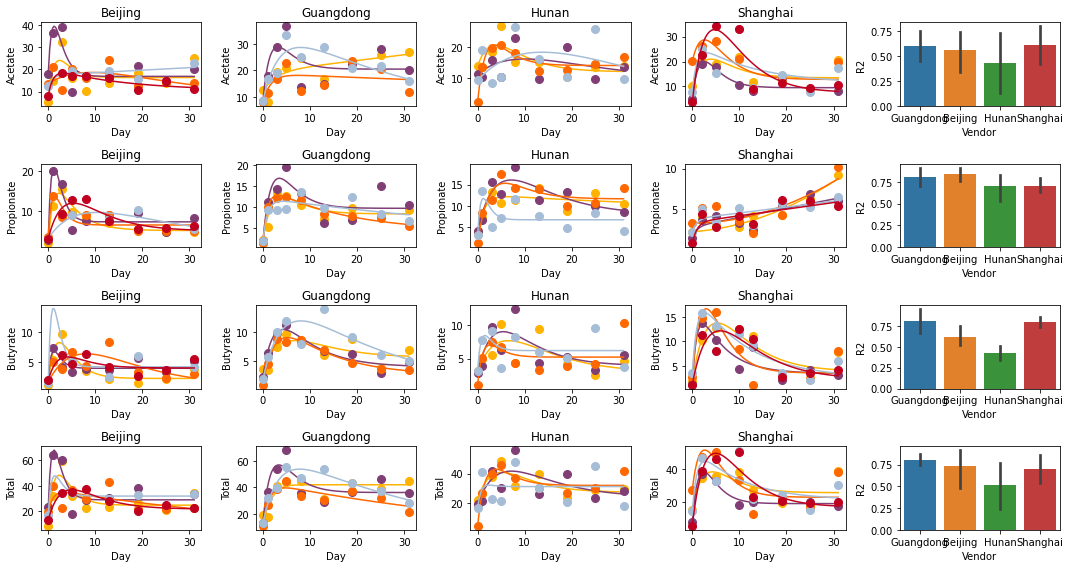

In [6]:
fig, ax = plt.subplots(figsize=(15, 8), nrows=4, ncols=5)
df_bfit = pd.read_csv('best_fit_parameters_inulin_fixedIC_harmonic.csv', index_col=0)

df_meta_scfa_inulin = df_meta_scfa[df_meta_scfa.Diet=='Inulin']
colors = ['#FFB300', # Vivid Yellow,
          '#803E75', # Strong Purple
          '#FF6800', # Vivid Orange
          '#A6BDD7', # Very Light Blue
          '#C10020'] # Vivid Red'
for i, scfa_ in enumerate(['Acetate','Propionate','Butyrate','Total']):
    for j, vendor_ in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
        curr_df = df_meta_scfa_inulin[df_meta_scfa_inulin.Vendor==vendor_]
        for k, mice_ in enumerate(set(curr_df.MiceID)):
            curr_df2 = curr_df[curr_df.MiceID==mice_].sort_values(by='Day')
            
            # get X and Y data
            xdata = np.array(curr_df2.Day)
            ydata = np.array(curr_df2[scfa_])
            ax[i,j].plot(xdata, ydata, marker='o', linestyle = 'None', markersize=8, color=colors[k])

            xdata_dense = np.linspace(0,31,100)
            best_sol_over = df_bfit.loc[(df_bfit.MiceID==mice_)&(df_bfit.SCFA==scfa_), ['k1','k2','D','H','Ai']].values[0]
            ypred = harmonic(best_sol_over, xdata_dense)
            ax[i,j].plot(xdata_dense, ypred, color=colors[k])
            ax[i,j].set_title(vendor_)
            ax[i,j].set_xlabel('Day')
            ax[i,j].set_ylabel(scfa_)
    
    # plot R2
    _ = sns.barplot(x='Vendor', y='R2', data=df_bfit.loc[df_bfit.SCFA==scfa_], ax=ax[i,4])
                
plt.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("harmonic_fitting_scfa_inulin_fixedIC.svg", format="svg")

# Analyze individualized response for D and zeta

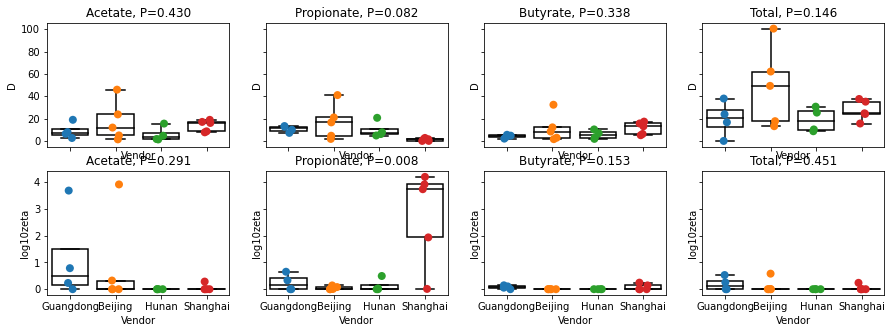

In [11]:
df_bfit = pd.read_csv('best_fit_parameters_inulin_fixedIC_harmonic.csv', index_col=0)
df_bfit['log10zeta'] = np.log10(df_bfit['zeta'])
df_bfit = df_bfit[['MiceID','SCFA','Vendor','D','log10zeta']]

# plot statistical comparison
fig, ax = plt.subplots(figsize=(15, 5), nrows=2, ncols=4, sharex=True, sharey='row')
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

for i,par in enumerate(['D','log10zeta']):
    for j,scfa in enumerate(['Acetate','Propionate','Butyrate','Total']):
        df_tmp = df_bfit[df_bfit.SCFA==scfa]
        _ = sns.boxplot(x='Vendor', y=par, hue='Vendor',data=df_tmp, color=None, dodge=False, ax=ax[i,j], showfliers=False, **PROPS)
        _ = sns.stripplot(x='Vendor', y=par, data=df_tmp, size=8, dodge=False, ax=ax[i,j])
        _ = ax[i,j].legend().remove()

        # group-wise test
        dm = pdist(np.asarray(df_tmp[par].values).reshape(-1,1), metric='minkowski')
        DM = DistanceMatrix(dm,list(df_tmp.MiceID))
        stats = permanova(DM, grouping=list(df_tmp.Vendor), permutations=999)
        _ = ax[i,j].set_title('%s, P=%2.3f'%(scfa, stats['p-value']))

# save figure
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("individualized_response_harmonic_model_D_log10zeta.svg", format="svg")